In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d, UnivariateSpline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [2]:
# Load data
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("Sample submission shape:", sample_sub.shape)

print("\nTraining data head:")
display(train.head())

print("\nTest data head:")
display(test.head())

Training data shape: (178340, 97)
Test data shape: (12065, 96)
Sample submission shape: (12065, 53)

Training data head:


,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063



Test data head:


,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,NaN,NaN,NaN,0.242149,NaN,0.232439,NaN,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,NaN,0.258893,NaN,NaN,NaN,0.233548,NaN,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,NaN,0.251731,NaN,NaN,0.214869,0.20458,0.194604,NaN,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,NaN,0.220505,NaN,0.198602,0.18619,NaN,NaN,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,NaN,0.222983,0.214126,NaN,NaN,0.192603,NaN,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06


# Data Exploration

In [3]:
# Get all IV columns from TEST data
iv_columns = [col for col in test.columns if col.startswith(('call_iv_', 'put_iv_'))]

print(f"Found {len(iv_columns)} IV columns in test data")
print("First 10 IV columns:", iv_columns[:10])

Found 52 IV columns in test data
First 10 IV columns: ['call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900']


# Strike Dictionary Creation

In [5]:
# Create strike dictionary from TEST columns
strike_dict = {}
for col in iv_columns:
    strike = col.split('_')[-1]
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

print(f"Created strike dictionary with {len(strike_dict)} unique strikes")
print("Example strike dictionary entries:")
for i, (strike, cols) in enumerate(strike_dict.items()):
    if i < 5:  # Print first 5 entries
        print(f"Strike {strike}: {cols}")

Created strike dictionary with 36 unique strikes
Example strike dictionary entries:
Strike 24000: {'call': 'call_iv_24000', 'put': 'put_iv_24000'}
Strike 24100: {'call': 'call_iv_24100', 'put': 'put_iv_24100'}
Strike 24200: {'call': 'call_iv_24200', 'put': 'put_iv_24200'}
Strike 24300: {'call': 'call_iv_24300', 'put': 'put_iv_24300'}
Strike 24400: {'call': 'call_iv_24400', 'put': 'put_iv_24400'}


# Global Statistics Calculation

In [6]:
# Pre-calculate global means and standard deviations from training data
global_stats = {}
for col in iv_columns:
    if col in train.columns:
        global_stats[col] = {
            'mean': train[col].mean(),
            'std': train[col].std()
        }
overall_mean = np.mean([stats['mean'] for stats in global_stats.values()]) if global_stats else 0.2

print(f"Calculated global stats for {len(global_stats)} columns")
print(f"Overall mean IV across all strikes: {overall_mean:.4f}")

Calculated global stats for 42 columns
Overall mean IV across all strikes: -12.4045


# Helper Functions

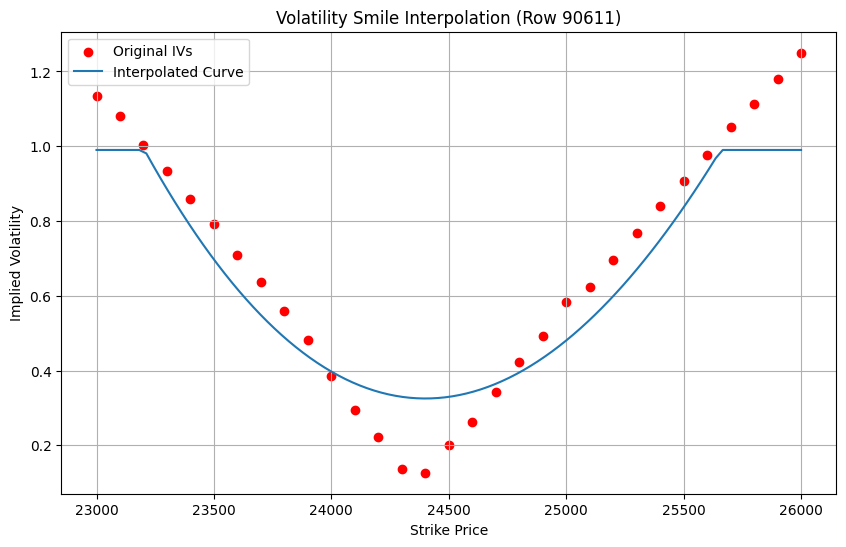

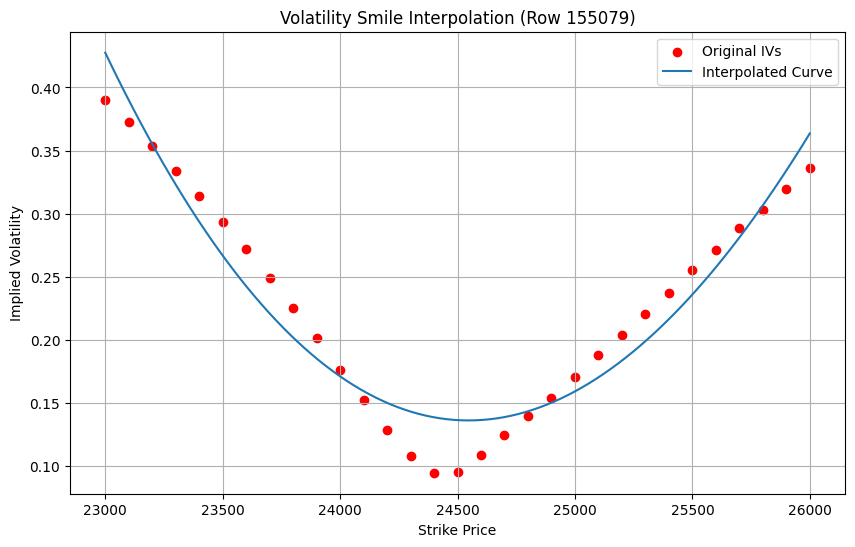

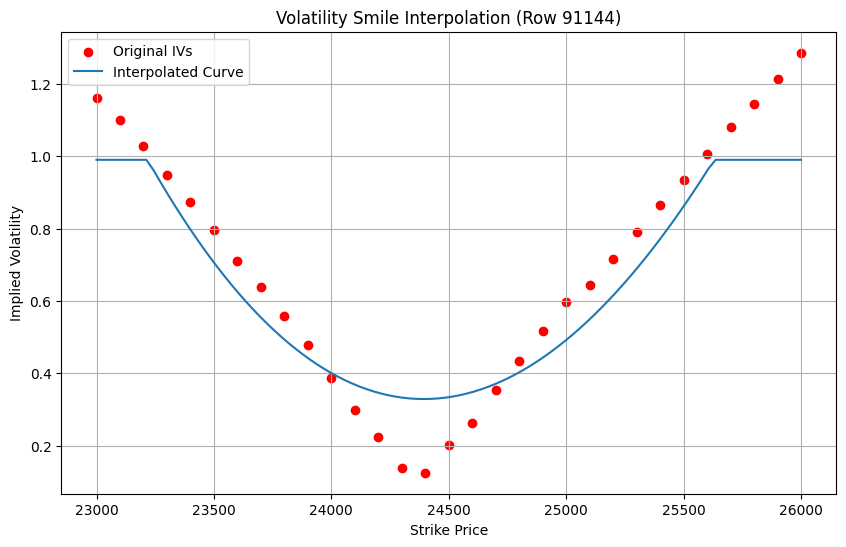

In [7]:
def extract_strike_price(strike_str):
    try:
        return float(strike_str)
    except:
        return 0.0

def biquadratic_interpolation(strikes, ivs, target_strike):
    """Biquadratic interpolation for volatility smile"""
    if len(strikes) < 3:
        return np.mean(ivs) if ivs else overall_mean
    
    # Convert to log-moneyness space
    log_strikes = np.log(np.array(strikes))
    log_target = np.log(target_strike)
    
    # Fit biquadratic function: ax^2 + bx + c
    coeffs = np.polyfit(log_strikes, ivs, 2)
    interpolated = np.polyval(coeffs, log_target)
    
    return np.clip(interpolated, 0.01, 0.99)

# Visualize interpolation for a sample row
def visualize_interpolation(row_idx):
    row = train.iloc[row_idx]
    
    available_ivs = []
    available_strikes = []
    
    for col in iv_columns:
        if col in row and not pd.isna(row[col]):
            strike = extract_strike_price(col.split('_')[-1])
            available_ivs.append(row[col])
            available_strikes.append(strike)
    
    if len(available_ivs) >= 3:
        strike_iv_dict = {}
        for strike, iv in zip(available_strikes, available_ivs):
            if strike not in strike_iv_dict:
                strike_iv_dict[strike] = []
            strike_iv_dict[strike].append(iv)
        
        unique_strikes = []
        unique_ivs = []
        for strike in sorted(strike_iv_dict.keys()):
            unique_strikes.append(strike)
            unique_ivs.append(np.mean(strike_iv_dict[strike]))
        
        # Plot original points
        plt.figure(figsize=(10, 6))
        plt.scatter(unique_strikes, unique_ivs, color='red', label='Original IVs')
        
        # Plot interpolated curve
        x_range = np.linspace(min(unique_strikes), max(unique_strikes), 100)
        y_interp = [biquadratic_interpolation(unique_strikes, unique_ivs, x) for x in x_range]
        plt.plot(x_range, y_interp, label='Interpolated Curve')
        
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        plt.title(f'Volatility Smile Interpolation (Row {row_idx})')
        plt.legend()
        plt.grid()
        plt.show()

# Visualize for a few random rows
for i in np.random.choice(len(train), 3):
    visualize_interpolation(i)

# IV Prediction Function

In [8]:
def predict_iv(data):
    data = data.copy()
    
    # Phase 1: Strict put-call parity
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Fill calls using puts where possible
            call_mask = data[call_col].isna() & data[put_col].notna()
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col]
            
            # Fill puts using calls where possible
            put_mask = data[put_col].isna() & data[call_col].notna()
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col]
    
    # Phase 2: Biquadratic interpolation
    for idx, row in data.iterrows():
        # Get timestamp for this row
        current_time = row['timestamp']
        
        # Collect all available IV values in this row with their strikes
        available_ivs = []
        available_strikes = []
        
        for col in iv_columns:
            if col in row and not pd.isna(row[col]):
                strike = extract_strike_price(col.split('_')[-1])
                available_ivs.append(row[col])
                available_strikes.append(strike)
        
        if len(available_ivs) >= 3:  # Need at least 3 points for biquadratic
            # Create a dictionary to handle duplicate strikes
            strike_iv_dict = {}
            for strike, iv in zip(available_strikes, available_ivs):
                if strike not in strike_iv_dict:
                    strike_iv_dict[strike] = []
                strike_iv_dict[strike].append(iv)
            
            # Average IVs for duplicate strikes
            unique_strikes = []
            unique_ivs = []
            for strike in sorted(strike_iv_dict.keys()):
                unique_strikes.append(strike)
                unique_ivs.append(np.mean(strike_iv_dict[strike]))
            
            # Apply biquadratic interpolation to missing values
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    strike = extract_strike_price(col.split('_')[-1])
                    try:
                        interpolated_value = biquadratic_interpolation(unique_strikes, unique_ivs, strike)
                        data.at[idx, col] = interpolated_value
                    except:
                        # Fallback to row mean if interpolation fails
                        data.at[idx, col] = np.mean(available_ivs)
        else:
            # If not enough points for interpolation, use row mean
            row_mean = np.mean(available_ivs) if available_ivs else overall_mean
            
            # Apply row mean to all missing IVs in this row
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    data.at[idx, col] = row_mean
    
    # Phase 3: Enhanced smoothing to maintain volatility smile shape
    for idx, row in data.iterrows():
        for strike, cols in strike_dict.items():
            call_col = cols['call']
            put_col = cols['put']
            
            if call_col in data.columns and put_col in data.columns:
                # Calculate average of call and put IVs
                avg_iv = (data.at[idx, call_col] + data.at[idx, put_col]) / 2
                
                # Apply stronger smoothing for biquadratic interpolation
                data.at[idx, call_col] = 0.85 * data.at[idx, call_col] + 0.15 * avg_iv
                data.at[idx, put_col] = 0.85 * data.at[idx, put_col] + 0.15 * avg_iv
    
    return data

# Validation Split

In [9]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print("Training split shape:", train_df.shape)
print("Validation split shape:", val_df.shape)

Training split shape: (142672, 97)
Validation split shape: (35668, 97)


# Validation Prediction

In [10]:
# Apply to validation set
val_pred = predict_iv(val_df)

# Calculate MSE only on originally masked validation points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Focus only on points that were originally missing
        mask = val_df[col].isna() & val_pred[col].notna()
        if mask.any():
            se = (val_df.loc[mask, col] - val_pred.loc[mask, col]) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Validation MSE (masked points only): {validation_mse:.12f}")

Validation MSE (masked points only): 0.000000000000


# Test Prediction

In [11]:
# Apply to test set
test_pred = predict_iv(test)

# Show before/after missing values
print("Missing values in test data before prediction:")
print(test[iv_columns].isna().sum().sum())

print("\nMissing values in test data after prediction:")
print(test_pred[iv_columns].isna().sum().sum())

Missing values in test data before prediction:
376504

Missing values in test data after prediction:
0


# Submission Preparation

In [12]:
# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()
submission.columns = sample_sub.columns

# Verify no missing values
assert submission.isna().sum().sum() == 0, "Missing values detected"
submission.to_csv('submission.csv', index=False)

print("\nFinal Submission Preview:")
display(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Validation MSE: {validation_mse:.12f}")


Final Submission Preview:


,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.265319,0.254828,0.246216,0.242149,0.234537,0.232431,0.230100,0.222997,...,0.232342,0.230100,0.222997,0.227351,0.234169,0.245304,0.250706,0.258529,0.269138,0.282396
1,1,0.271662,0.269782,0.258893,0.251917,0.244875,0.240772,0.233548,0.228209,0.236305,...,0.233548,0.228209,0.236305,0.229917,0.241265,0.249402,0.257819,0.260233,0.269557,0.284057
2,2,0.238583,0.251622,0.220023,0.212586,0.214869,0.204580,0.194605,0.188052,0.193240,...,0.194611,0.188052,0.193240,0.180668,0.181346,0.185130,0.190750,0.197133,0.207424,0.213567
3,3,0.241888,0.218590,0.220505,0.210733,0.198602,0.186190,0.185974,0.166394,0.161561,...,0.185974,0.166394,0.161561,0.182086,0.183311,0.172032,0.181429,0.194333,0.200409,0.206424
4,4,0.235328,0.222370,0.223038,0.214126,0.199931,0.199485,0.192603,0.186420,0.183845,...,0.192603,0.186420,0.183845,0.177920,0.181518,0.176012,0.177836,0.178878,0.182345,0.188761



Submission shape: (12065, 53)
Validation MSE: 0.000000000000


# Visualizing Predictions

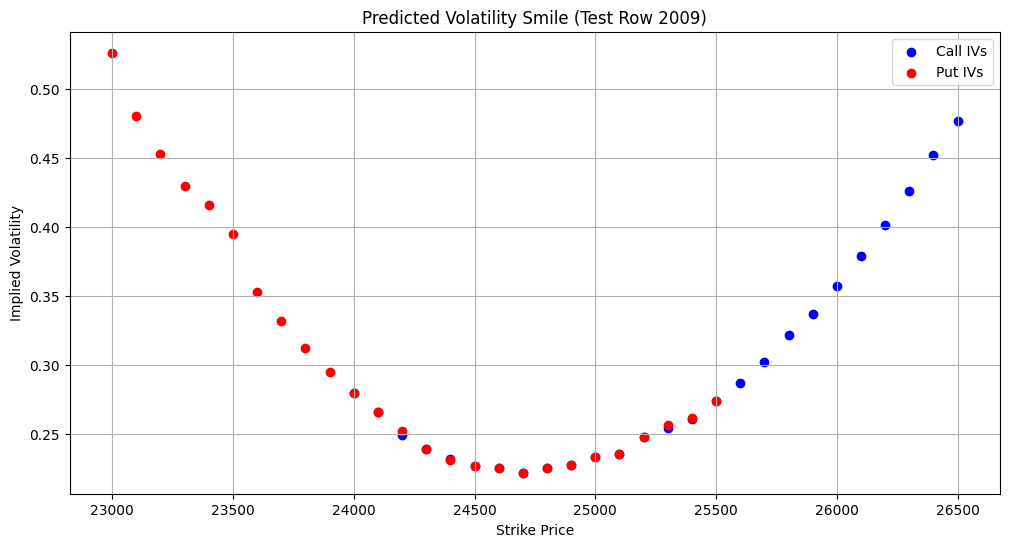

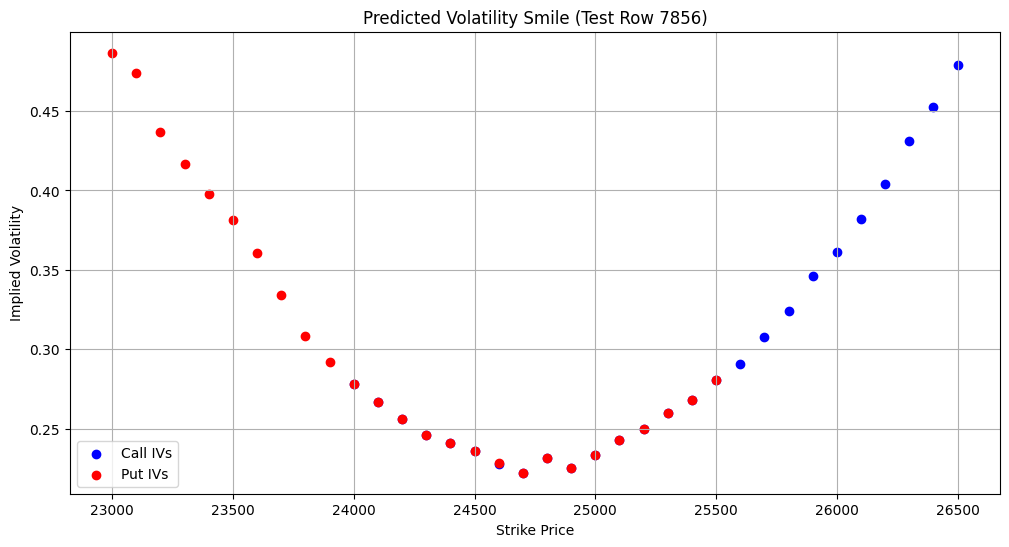

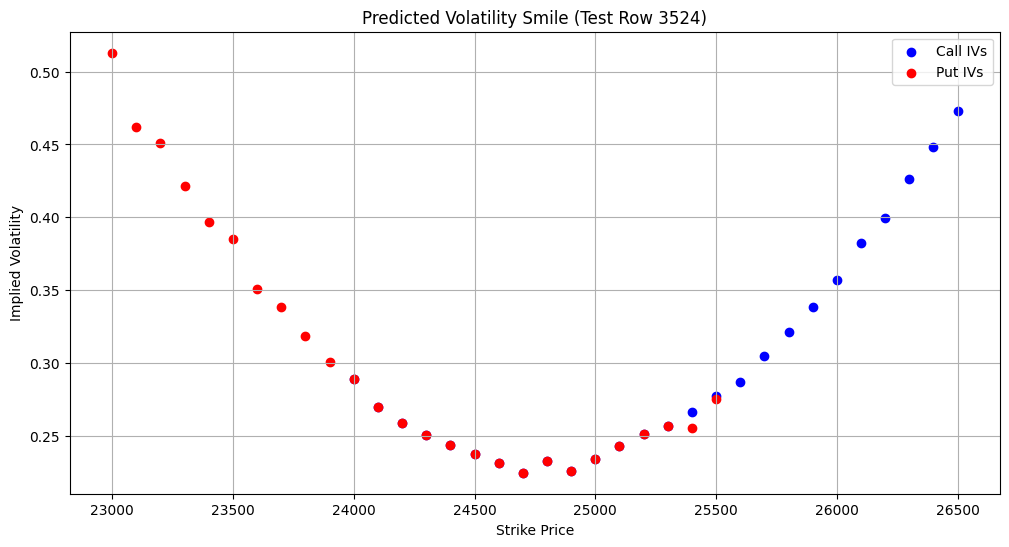

In [13]:
# Plot a random test prediction
def plot_test_prediction(row_idx):
    plt.figure(figsize=(12, 6))
    
    # Get call and put IVs separately
    call_cols = [col for col in iv_columns if col.startswith('call_iv_')]
    put_cols = [col for col in iv_columns if col.startswith('put_iv_')]
    
    # Extract strikes
    call_strikes = [extract_strike_price(col.split('_')[-1]) for col in call_cols]
    put_strikes = [extract_strike_price(col.split('_')[-1]) for col in put_cols]
    
    # Get IV values
    call_ivs = test_pred.loc[row_idx, call_cols].values
    put_ivs = test_pred.loc[row_idx, put_cols].values
    
    plt.scatter(call_strikes, call_ivs, color='blue', label='Call IVs')
    plt.scatter(put_strikes, put_ivs, color='red', label='Put IVs')
    
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title(f'Predicted Volatility Smile (Test Row {row_idx})')
    plt.legend()
    plt.grid()
    plt.show()

# Plot a few random test predictions
for i in np.random.choice(len(test_pred), 3):
    plot_test_prediction(i)